In [1]:
import psycopg2
import numpy as np
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

In [2]:
hostname = 'spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com'
username = 'introml568'
password = 'm7bxMRtyMqPbcxyRRGML8'
database_name = 'synthea-omop'

In [3]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [4]:
# Read in OMOP
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);
omop_death = pd.read_sql("select * from omop.death", db_connection);
omop_concept = pd.read_sql("select * from omop.concept", db_connection); 
omop_measurement = pd.read_sql("select * from omop.measurement", db_connection);

In [5]:
# Read in occurrence
occurrence = pd.read_sql("select * from omop.condition_occurrence", db_connection)

In [6]:
# Merge omop_person and omop_visit
df = pd.merge(omop_person, omop_visit, on='person_id', how="inner")

In [7]:
# Get age
def person_age(birthdate):
    difference_in_years = relativedelta(datetime.now(), birthdate).years
    return difference_in_years
df['age'] = df.birth_datetime.apply(person_age)

In [8]:
# Get age at visit
df['age_at_visit'] = df.apply(lambda x: relativedelta(x['visit_start_datetime'], x['birth_datetime']).years, axis=1)

In [9]:
# Get visit length 
df['visit_length'] = df.apply(lambda x: relativedelta(x['visit_end_datetime'], x['visit_start_datetime']).days, axis=1)

In [10]:
# Subset condition for omop_concept table
omop_concept_2 = omop_concept.loc[((omop_concept['concept_name'].str.contains("Diabetes",case=False))|
                                 (omop_concept['concept_name'].str.contains("Hypertension",case=False)))&
                                (omop_concept['domain_id']=='Condition')]

In [11]:
# Create condition table
omop_concept_2 = pd.merge(omop_concept_2,occurrence,left_on='concept_id',right_on='condition_concept_id',how='inner')
omop_concept_2 = omop_concept_2[['person_id','concept_name']]

In [12]:
# Left Join condition onto df
df = pd.merge(df,omop_concept_2,on='person_id',how='left')
df = df.drop_duplicates(subset=['person_id','visit_occurrence_id'])

In [13]:
# Create column of conditions
df['hypertension'] = df['concept_name'].str.contains('hypertension',case=False,na=False).astype('int')
df['diabetes'] = df['concept_name'].str.contains('diabetes',case=False,na=False).astype('int')

In [14]:
# Merge omop_measurement with omop_concept
measurements = pd.merge(omop_measurement, omop_concept, left_on='measurement_concept_id', right_on='concept_id', how="left")

In [15]:
# Subset measurements table
measurements = measurements[['person_id','visit_occurrence_id','value_as_number','concept_name']]

# Pivot table
measurements = measurements.drop_duplicates(subset=['person_id','visit_occurrence_id','concept_name'])
measurements = measurements.pivot(index=['person_id','visit_occurrence_id'],columns='concept_name',values='value_as_number')
measurements.reset_index(inplace=True)
measurements.columns.name = None

In [23]:
# Keep column
col_keep = ['visit_start_date','person_id', 'gender_concept_id','age','provider_id_y','age_at_visit','race_source_value',
            'ethnicity_source_value', 'visit_length','hypertension','diabetes','visit_occurrence_id']
df = df[col_keep]

In [24]:
# Merge measurements with df
measurements = measurements[~measurements['visit_occurrence_id'].isnull()]
measurements['visit_occurrence_id'] = measurements['visit_occurrence_id'].astype('int')
df = pd.merge(df,measurements,on=['person_id','visit_occurrence_id'],how='left')

In [25]:
# Inclusion visit 1-37
df['COUNTER'] = df.groupby(['person_id']).cumcount()+1; df
df = df[df['COUNTER'] < 38]

In [26]:
# Inclusion age 52-56
df = df[(df['age']>=52)&(df['age']<=56)]

In [27]:
# Inclusion living patients 
df = df.loc[~df['person_id'].isin(omop_death.person_id.unique())]

In [28]:
# Drop counter column
df = df.drop(columns=['COUNTER'])

In [29]:
# Exclusion for visits which do not contain any associated measurements
df = df[~df.iloc[:,12:].isnull().all(axis=1)]

In [30]:
# Exclusion for sum of 3-17 ...
temp1 = omop_concept[(omop_concept['concept_name'].str.contains('systolic blood pressure',case=False))&
             (omop_concept['domain_id']=='Measurement')]
temp2 = pd.merge(omop_measurement,temp1,left_on='measurement_concept_id',right_on='concept_id',how='inner')
temp2 = temp2[temp2['value_as_number']>140]
# Count the number of visit with high systolic blood pressure
temp3 = pd.DataFrame(temp2.groupby(['person_id'])['person_id'].count())
# Get the excluded person id
exclusion_id = np.array(temp3[(temp3['person_id']>3)|(temp3['person_id']<17)].index)
df = df[~df['person_id'].isin(exclusion_id)]

In [31]:
# Rest index
df.reset_index(drop=True,inplace=True)

In [33]:
# Save the dataframe
temp = df.drop(columns=['age','provider_id_y'])
temp.to_csv('dat.csv')

In [34]:
temp

,visit_start_date,person_id,gender_concept_id,age_at_visit,race_source_value,ethnicity_source_value,visit_length,hypertension,diabetes,visit_occurrence_id,...,Urine protein measurement,Urine screening for glucose,Urine screening test for diabetes,Walnut IgE Ab [Units/volume] in Serum,Weight difference [Mass difference] --pre dialysis - post dialysis,Weight-for-length Per age and sex,Wheat IgE Ab [Units/volume] in Serum,White Oak IgE Ab [Units/volume] in Serum,pH of Arterial blood,pH of Urine by Test strip
0,2012-12-03,18,8507,44,white,nonhispanic,0,0,0,817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-08,18,8507,46,white,nonhispanic,0,0,0,815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-12-12,18,8507,48,white,nonhispanic,0,0,0,814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-17,18,8507,49,white,nonhispanic,0,0,0,823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-19,18,8507,50,white,nonhispanic,0,0,0,810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,2020-03-06,11954,8507,49,asian,nonhispanic,0,0,0,556947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5590,2020-09-01,11954,8507,50,asian,nonhispanic,0,0,0,556948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5591,2021-09-07,11954,8507,51,asian,nonhispanic,0,0,0,556959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5592,2022-07-07,11954,8507,51,asian,nonhispanic,0,0,0,556950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Age at visit')

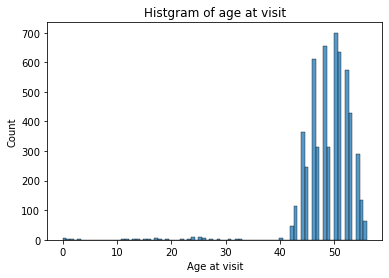

In [35]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df,x='age_at_visit')
plt.title("Histgram of age at visit")
plt.xlabel("Age at visit")

Text(0.5, 0, 'Gender concept id')

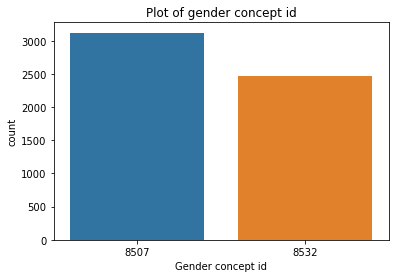

In [36]:
df['gender_concept_id'] = df[['gender_concept_id']].astype('object')
sns.countplot(data=df,x='gender_concept_id')
plt.title("Plot of gender concept id")
plt.xlabel("Gender concept id")

Text(0.5, 1.0, 'Histgram of race')

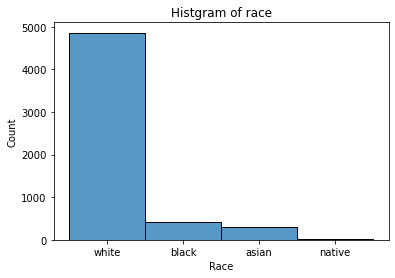

In [37]:
sns.histplot(data=df,x='race_source_value')
plt.xlabel("Race")
plt.title("Histgram of race")

Text(0.5, 1.0, 'Histgram visit length')

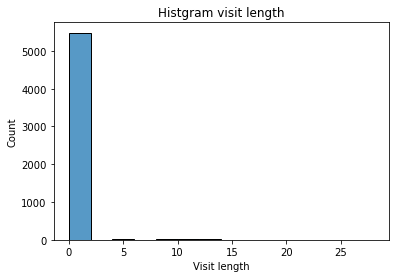

In [38]:
sns.histplot(data=df,x='visit_length')
plt.xlabel("Visit length")
plt.title("Histgram visit length")

Text(0, 0.5, 'age at visit')

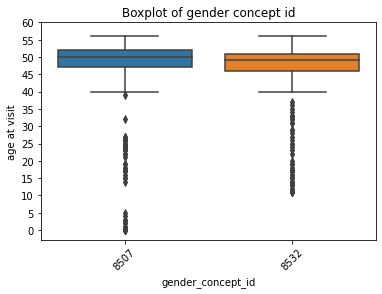

In [39]:
sns.boxplot(data=df,y='age_at_visit',x='gender_concept_id')
plt.title("Boxplot of gender concept id")
plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.xticks(rotation=45);
plt.ylabel("age at visit")

Text(0, 0.5, 'age at visit')

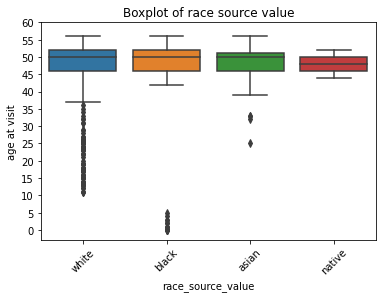

In [40]:
sns.boxplot(data=df,y='age_at_visit',x='race_source_value')
plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.title("Boxplot of race source value")
plt.xticks(rotation=45);
plt.ylabel("age at visit")

Text(0, 0.5, 'age at visit')

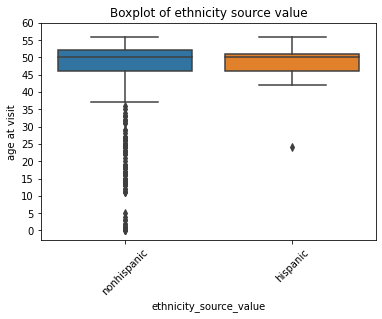

In [41]:
sns.boxplot(data=df,y='age_at_visit',x='ethnicity_source_value')
plt.title("Boxplot of ethnicity source value")
plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.xticks(rotation=45);
plt.ylabel("age at visit")

In [44]:
# Information on patient admit and discharge
omop_provider = pd.read_sql("select * from omop.provider", db_connection);
omop_provider = omop_provider[['provider_id','provider_name']]
omop_provider

,provider_id,provider_name
0,1,Reginald96 Bruen238
1,2,Arturo47 Gurule738
2,3,Juan88 Rodarte647
3,4,Dagny669 Wyman904
4,5,Wilfredo622 Medhurst46
...,...,...
34093,34094,Enrique929 Armendáriz135
34094,34095,Violeta106 Walter473
34095,34096,Seymour882 Veum823
34096,34097,Dwain139 Bailey598


In [46]:
df = pd.merge(df,omop_provider,left_on='provider_id_y',right_on='provider_id',how='left')

Text(0, 0.5, 'age at visit')

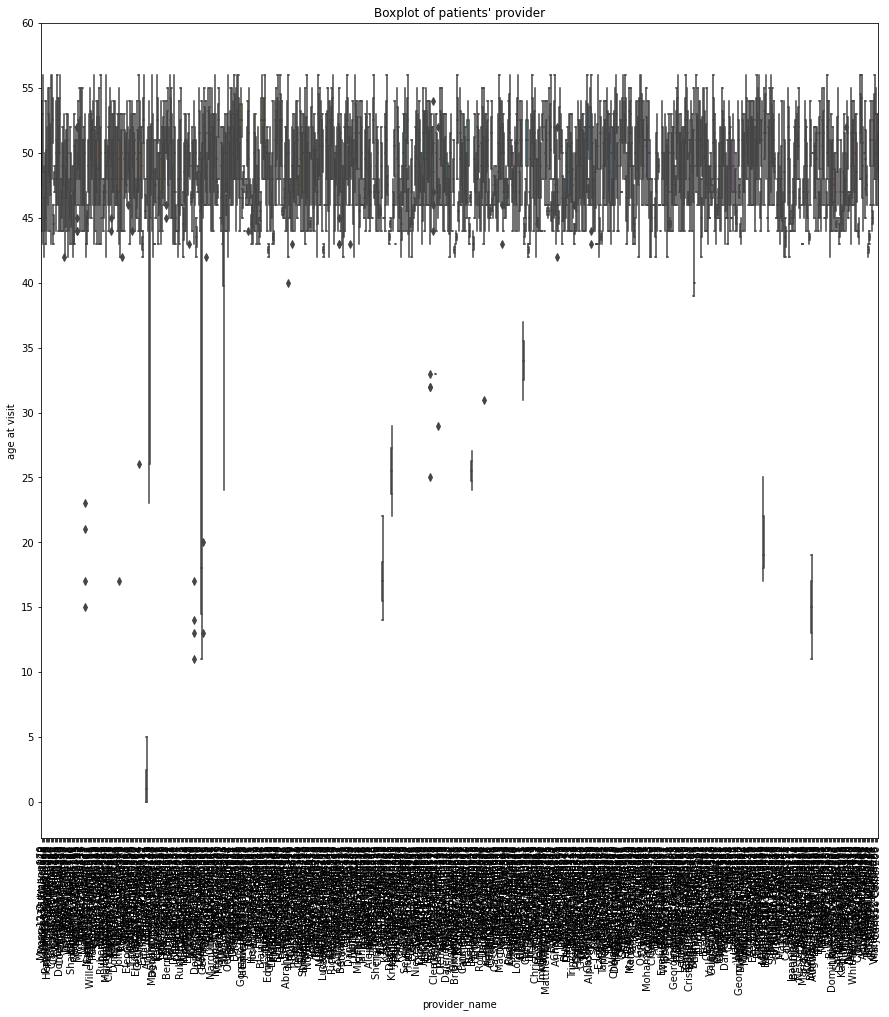

In [50]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=df,y='age_at_visit',x='provider_name')
plt.title("Boxplot of patients' provider")
plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.xticks(rotation=90);
plt.ylabel("age at visit")